## Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
import re
import pymorphy2
import string
from nltk.stem import WordNetLemmatizer
from tqdm import *
from tqdm.notebook import tqdm
from tqdm import notebook
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_issues_train = pd.read_csv(r"C:\work\Всероссийский_чемпионат\collector\train_dataset_train/train_issues.csv")
df_comment_train = pd.read_csv(r"C:\work\Всероссийский_чемпионат\collector\train_dataset_train/train_comments.csv")

df_emp = pd.read_csv(r"C:\work\Всероссийский_чемпионат\collector\AltGU/employees.csv")

In [3]:
df_issues_test = pd.read_csv(r"C:\work\Всероссийский_чемпионат\collector\test_dataset_test/test_issues.csv")
df_comment_test = pd.read_csv(r"C:\work\Всероссийский_чемпионат\collector\test_dataset_test/test_comments.csv")


In [4]:
df_issues_train.overall_worklogs = np.log1p(df_issues_train.overall_worklogs)# прологарифмируем целевую переменную

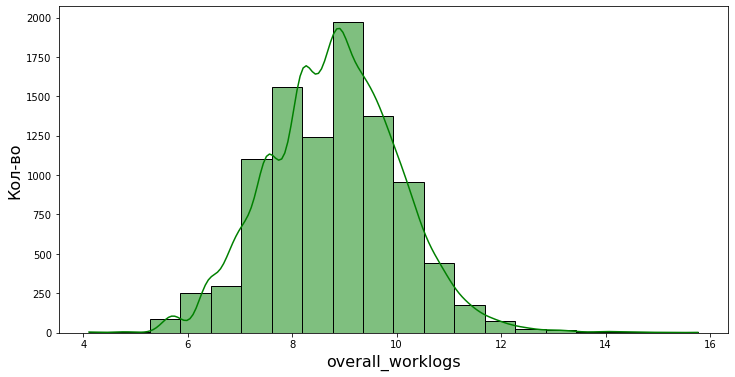

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(x='overall_worklogs', kde=True, bins=20, color = 'green',data=df_issues_train)
plt.xlabel('overall_worklogs', fontsize=16)
plt.ylabel("Кол-во", fontsize=16)
plt.show()

In [6]:
data_comment = pd.concat([df_comment_train, df_comment_test], sort=False)

In [7]:
#data_comment['len_word_title'] = data_comment['text'].apply(lambda x: len(x.split()))
#data_comment['len_text'] = data_comment['text'].apply(len)

In [8]:
data_comment['author_issue']=data_comment['author_id'].astype(str)+' '+data_comment['issue_id'].astype(str)# создадим пару автор и задача

In [9]:
author_issue_list=data_comment.author_issue.unique().tolist()# список уникальных пар

In [10]:
# т.к. по каждой задаче есть несколько комментариев , то суммирум все комменты общим текстом по автору и задаче
com_text_author=pd.DataFrame()
for x in notebook.tqdm(author_issue_list):
    df=data_comment[data_comment["author_issue"]==x]
    df["text_author_com"]=df["text"].sum()
    com_text_author=com_text_author.append(df)
    com_text_author=com_text_author.drop_duplicates(subset=['author_issue'])

  0%|          | 0/5670 [00:00<?, ?it/s]

In [11]:
text=dict(zip(com_text_author.author_issue,com_text_author.text_author_com))# создадим словарь для переноса комментарием по задаче и автору
position=dict(zip(df_emp.id,df_emp.position))# также словарь для переноса должности сотрудника выполняющего задачу

In [12]:
# Ниже для подсчета количества задач по каждому "assignee_id" в час, день, месяц. А так же увеличивалось количество задач. В день было посчитано количество сформированных проектов.

In [13]:
def feature_data(df):
    data_feature=pd.DataFrame()
    feature_data=df.data.unique().tolist()
    for x in notebook.tqdm(feature_data):
        df_data=df[df["data"]==x]
        feature_df_data=df_data.assignee_id.unique().tolist()
        for i in feature_df_data:
            df_assignee=df_data[df_data["assignee_id"]==i]
            df_assignee["assignee_task_count_day"]=(df_assignee.duplicated(subset='assignee_id').sum())+1
            my_list = list(range(1, (len(df_assignee))+1))
            df_assignee["assignee_task_increasing_day"]=np.array(my_list)
            df_assignee['assignee_id__%_task_day']=df_assignee['assignee_task_increasing_day']/df_assignee['assignee_task_count_day']
            data_feature=data_feature.append(df_assignee)
    return feature_project_data(data_feature)

In [14]:
def feature_month(df):   
    month_feature=pd.DataFrame()
    feature_month=df.month.unique().tolist()
    for x in notebook.tqdm(feature_month):
        df_month=df[df["month"]==x]
        feature_df_month=df_month.assignee_id.unique().tolist()
        for i in feature_df_month:
            df_assignee=df_month[df_month["assignee_id"]==i]
            df_assignee["assignee_task_count_month"]=(df_assignee.duplicated(subset='assignee_id').sum())+1
            my_list = list(range(1, (len(df_assignee))+1))
            df_assignee["assignee_task_increasing_month"]=np.array(my_list)
            month_feature=month_feature.append(df_assignee)
    return feature_hour(month_feature)

In [15]:
def feature_hour(df):   
    hour_feature=pd.DataFrame()
    feature_hour=df.data_hour.unique().tolist()
    for x in notebook.tqdm(feature_hour):
        df_hour=df[df["data_hour"]==x]
        feature_df_hour=df_hour.assignee_id.unique().tolist()
        for i in feature_df_hour:
            df_assignee=df_hour[df_hour["assignee_id"]==i]
            df_assignee["assignee_task_count_hour"]=(df_assignee.duplicated(subset='assignee_id').sum())+1
            my_list = list(range(1, (len(df_assignee))+1))
            df_assignee["assignee_task_increasing_hour"]=np.array(my_list)
            df_assignee['assignee_id__hour_%_day']=df_assignee['assignee_task_count_hour']/df_assignee['assignee_task_count_day']
            df_assignee['assignee_id__hour_%']=df_assignee['assignee_task_increasing_hour']/df_assignee['assignee_task_count_hour']
            hour_feature=hour_feature.append(df_assignee)
    return hour_feature

In [16]:
def feature_project_data(df):
    data_feature=pd.DataFrame()
    feature_data=df.data.unique().tolist()
    for x in notebook.tqdm(feature_data):
        df_data=df[df["data"]==x]
        feature_df_data=df_data.project_id.unique().tolist()
        for i in feature_df_data:
            df_project=df_data[df_data["project_id"]==i]
            df_project["project_id_count_day"]=(df_project.duplicated(subset='project_id').sum())+1
            my_list = list(range(1, (len(df_project))+1))
            df_project["project_id_increasing_hour"]=np.array(my_list)
            data_feature=data_feature.append(df_project)
    return feature_month(data_feature)

In [17]:
def word_lang(df): # Для разбивки ключа задачи
    corpus = df['key'].str.lower().values
    corpus_number = []
    corpus_eng = []
    for i in notebook.tqdm(corpus):
        j=i
        j=re.sub(r"[^A-Za-z]","",j)
        i=re.sub(r"[^0-9^]","", i) 
        corpus_number.append(i)
        corpus_eng.append(j)
    return corpus_number, corpus_eng

In [18]:
# Ниже отсортируем по времение даты формирования задачи и трейн и тест. И создам переменную время от прошлого формирования задачи. 
df_issues_train['time'] = df_issues_train[['created']].apply(pd.to_datetime)
df_issues_train = df_issues_train.sort_values(by='time')

In [19]:
df_issues_test['time'] = df_issues_test[['created']].apply(pd.to_datetime)
df_issues_test = df_issues_test.sort_values(by='time')

In [20]:
df_issues_train['time_difference_task']=(df_issues_train['time']-df_issues_train['time'].shift(1)).dt.seconds
df_issues_test['time_difference_task']=(df_issues_test['time']-df_issues_test['time'].shift(1)).dt.seconds

In [21]:
idx = df_issues_train.shape[0]
data = pd.concat([df_issues_train, df_issues_test])

In [22]:
data['index']=np.array(range(len(data)))

In [23]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
morph = pymorphy2.MorphAnalyzer()# Для лемматизациия русских слов
stemmer = WordNetLemmatizer()# Для английских слов

In [24]:
def lemmatize_rus(text):
    words = text.split() 
    res=[]
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

In [25]:
def lemma_clean(df,col):# фунция для чиски текста
    corpus = df[col].values
    corpus_total = []
    for i in notebook.tqdm(corpus):
        
        j=i     
        j=re.sub(r"[^A-Za-z]"," ",j).lower()     
        j = j.lower()
        tokens = j.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        j = ' '.join(tokens)
        j = nltk.word_tokenize(j)
        j = [word for word in j if not  word in set(stopwords.words("english"))]
        word_eng = " ".join(j)
        
        i=re.sub(r"[^А-Яа-я^]"," ",str(i)).lower()
        i = nltk.word_tokenize(i)
        i = [word for word in i if not word in set(stopwords.words("russian"))]
     
        lem=[]
        for j in i:
            i = " ".join(lemmatize_rus(j))
            lem.append(i)
        
    
        word_rus = " ".join(lem)
        string_word = word_eng + ' '+ word_rus
        string_word = string_word.lstrip()
        
        
        corpus_total.append(string_word)
    return np.array(corpus_total)

In [26]:
data['summary_clean']=lemma_clean(data,'summary')


  0%|          | 0/10659 [00:00<?, ?it/s]

In [27]:
summary_clean = (data.summary_clean.map(lambda x : (''.join(x.split()[:1])))).tolist()

In [28]:
def top_words(corpus, i=None):
    vec = CountVectorizer(ngram_range=(1,1),max_features=3000)
    vec.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],reverse=True)
    return words_freq[:i]

[Text(0, 0, 'add'),
 Text(1, 0, 'fix'),
 Text(2, 0, 'create'),
 Text(3, 0, 'test'),
 Text(4, 0, 'check'),
 Text(5, 0, 'backend'),
 Text(6, 0, 'update'),
 Text(7, 0, 'research'),
 Text(8, 0, 'need'),
 Text(9, 0, 'frontend'),
 Text(10, 0, 'remove'),
 Text(11, 0, 'markup'),
 Text(12, 0, 'handle'),
 Text(13, 0, 'change'),
 Text(14, 0, 'implement'),
 Text(15, 0, 'teacher'),
 Text(16, 0, 'student'),
 Text(17, 0, 'incorrect'),
 Text(18, 0, 'добавить'),
 Text(19, 0, 'prepare'),
 Text(20, 0, 'refactor'),
 Text(21, 0, 'lesson'),
 Text(22, 0, 'planing'),
 Text(23, 0, 'canvas'),
 Text(24, 0, 'class'),
 Text(25, 0, 'api'),
 Text(26, 0, 'work'),
 Text(27, 0, 'move'),
 Text(28, 0, 'deploy'),
 Text(29, 0, 'delete')]

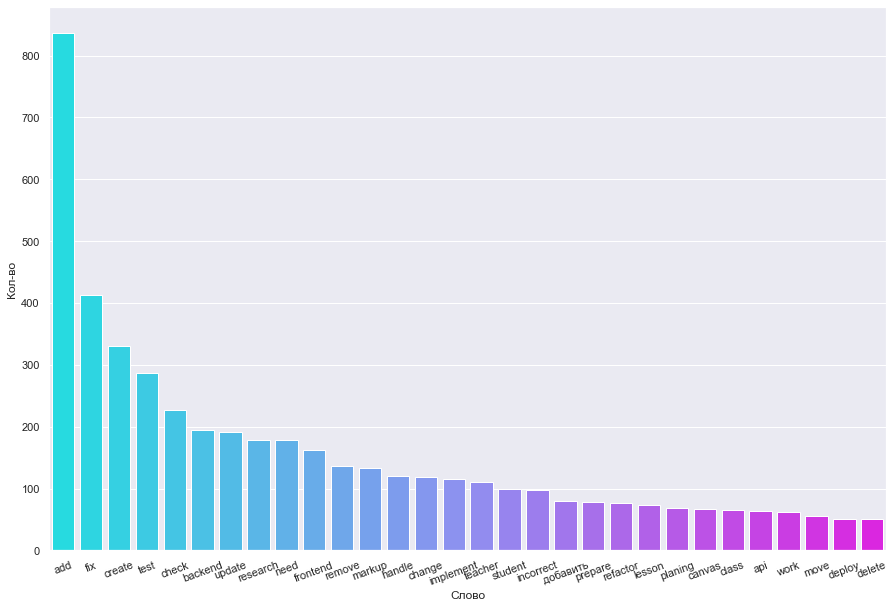

In [29]:
top_words_summary = top_words(summary_clean, i=30)
top_df_summary = pd.DataFrame(top_words_summary)
top_df_summary.columns=["Слово", "Кол-во"]
sns.set(rc={'figure.figsize':(15,10)})
g = sns.barplot(x="Слово", y="Кол-во", data=top_df_summary, palette='cool')
g.set_xticklabels(g.get_xticklabels(), rotation=20)

In [30]:
def feature_df(df_data):
    df=df_data.copy()
    df["year"] = df.created.map(lambda x : (x.split("-")[0]))
    df["data"] = df.created.map(lambda x : (x.split(" ")[0]))
    df["month"] = df.created.map(lambda x : int(x.split("-")[1]))
    df["day"] = df.created.map(lambda x : int(x.split("-")[2].split()[0]))
    df["hour_minits_seconds"] = df.created.map(lambda x : x.split(" ")[1])
    df["hour"] = df.hour_minits_seconds.map(lambda x : int(x.split(":")[0]))
    df["minits"] = df.hour_minits_seconds.map(lambda x : int(x.split(":")[1].split()[0]))
    df["seconds"] = df.hour_minits_seconds.map(lambda x : int(float(x.split(":")[2].split()[0])))
    
 
  
    df['data_hour']=df['data'].astype(str)+df['hour'].astype(str)
    df["summary_first"] = df.summary_clean.map(lambda x : (''.join(x.split()[:1])))
    df["summary_last"] = df.summary_clean.map(lambda x : (''.join(x.split()[-1])))
    
  
    
    df['week']= df['time'].map(lambda x : x.weekday())
    
 
    df['assignee_creator']=df['assignee_id'].astype(str)+df['creator_id'].astype(str)
    df['assignee_project']=df['assignee_id'].astype(str)+df['project_id'].astype(str)
    
    df['author_issue_id']=df['assignee_id'].astype(str)+' '+df['id'].astype(str)
    df['text_comment'] = df['author_issue_id'].apply(lambda x: text.get(x, 0))
    df['text_comment']=df['text_comment'].replace(0,' ')
   
    df['count_word_text_comment'] = df['text_comment'].apply(lambda x: len(x.split()))
    df['len_text_comment'] = df['text_comment'].apply(len)
    df['count_word_summary'] = df['summary'].apply(lambda x: len(x.split()))
    df['len_text_summary'] = df['summary'].apply(len)
      
    df['position'] = df['assignee_id'].apply(lambda x: position.get(x, 0))
    df.position=df.position.fillna('')
    df.time_difference_task=df.time_difference_task.fillna(0)

    corpus_number,corpus_eng=word_lang(df)
    df['key_numbers']=np.array(corpus_number)
    df['key_numbers']=df['key_numbers'].astype(int)
    df['key_word']=np.array(corpus_eng)
  
    df["assignee_creator"]=enc.fit_transform(np.array(df["assignee_creator"]).reshape(-1, 1)).astype(int)
    df["assignee_project"]=enc.fit_transform(np.array(df["assignee_project"]).reshape(-1, 1)).astype(int) 
    df["summary_first"]=enc.fit_transform(np.array(df["summary_first"]).reshape(-1, 1)).astype(int)
    df["summary_last"]=enc.fit_transform(np.array(df["summary_last"]).reshape(-1, 1)).astype(int)
    df["key_word"]=enc.fit_transform(np.array(df["key_word"]).reshape(-1, 1)).astype(int)
    df["data"]=enc.fit_transform(np.array(df["data"]).reshape(-1, 1)).astype(int)
    df["position"]=enc.fit_transform(np.array(df["position"]).reshape(-1, 1)).astype(int)

    df = df.sort_values(by='index')
 
    return df.drop('index', axis = 1)


In [31]:
new_data=feature_df(data)

  0%|          | 0/10659 [00:00<?, ?it/s]

In [32]:
train_final = feature_data(new_data[:idx])
test_final = feature_data(new_data[idx:])

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4234 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/574 [00:00<?, ?it/s]

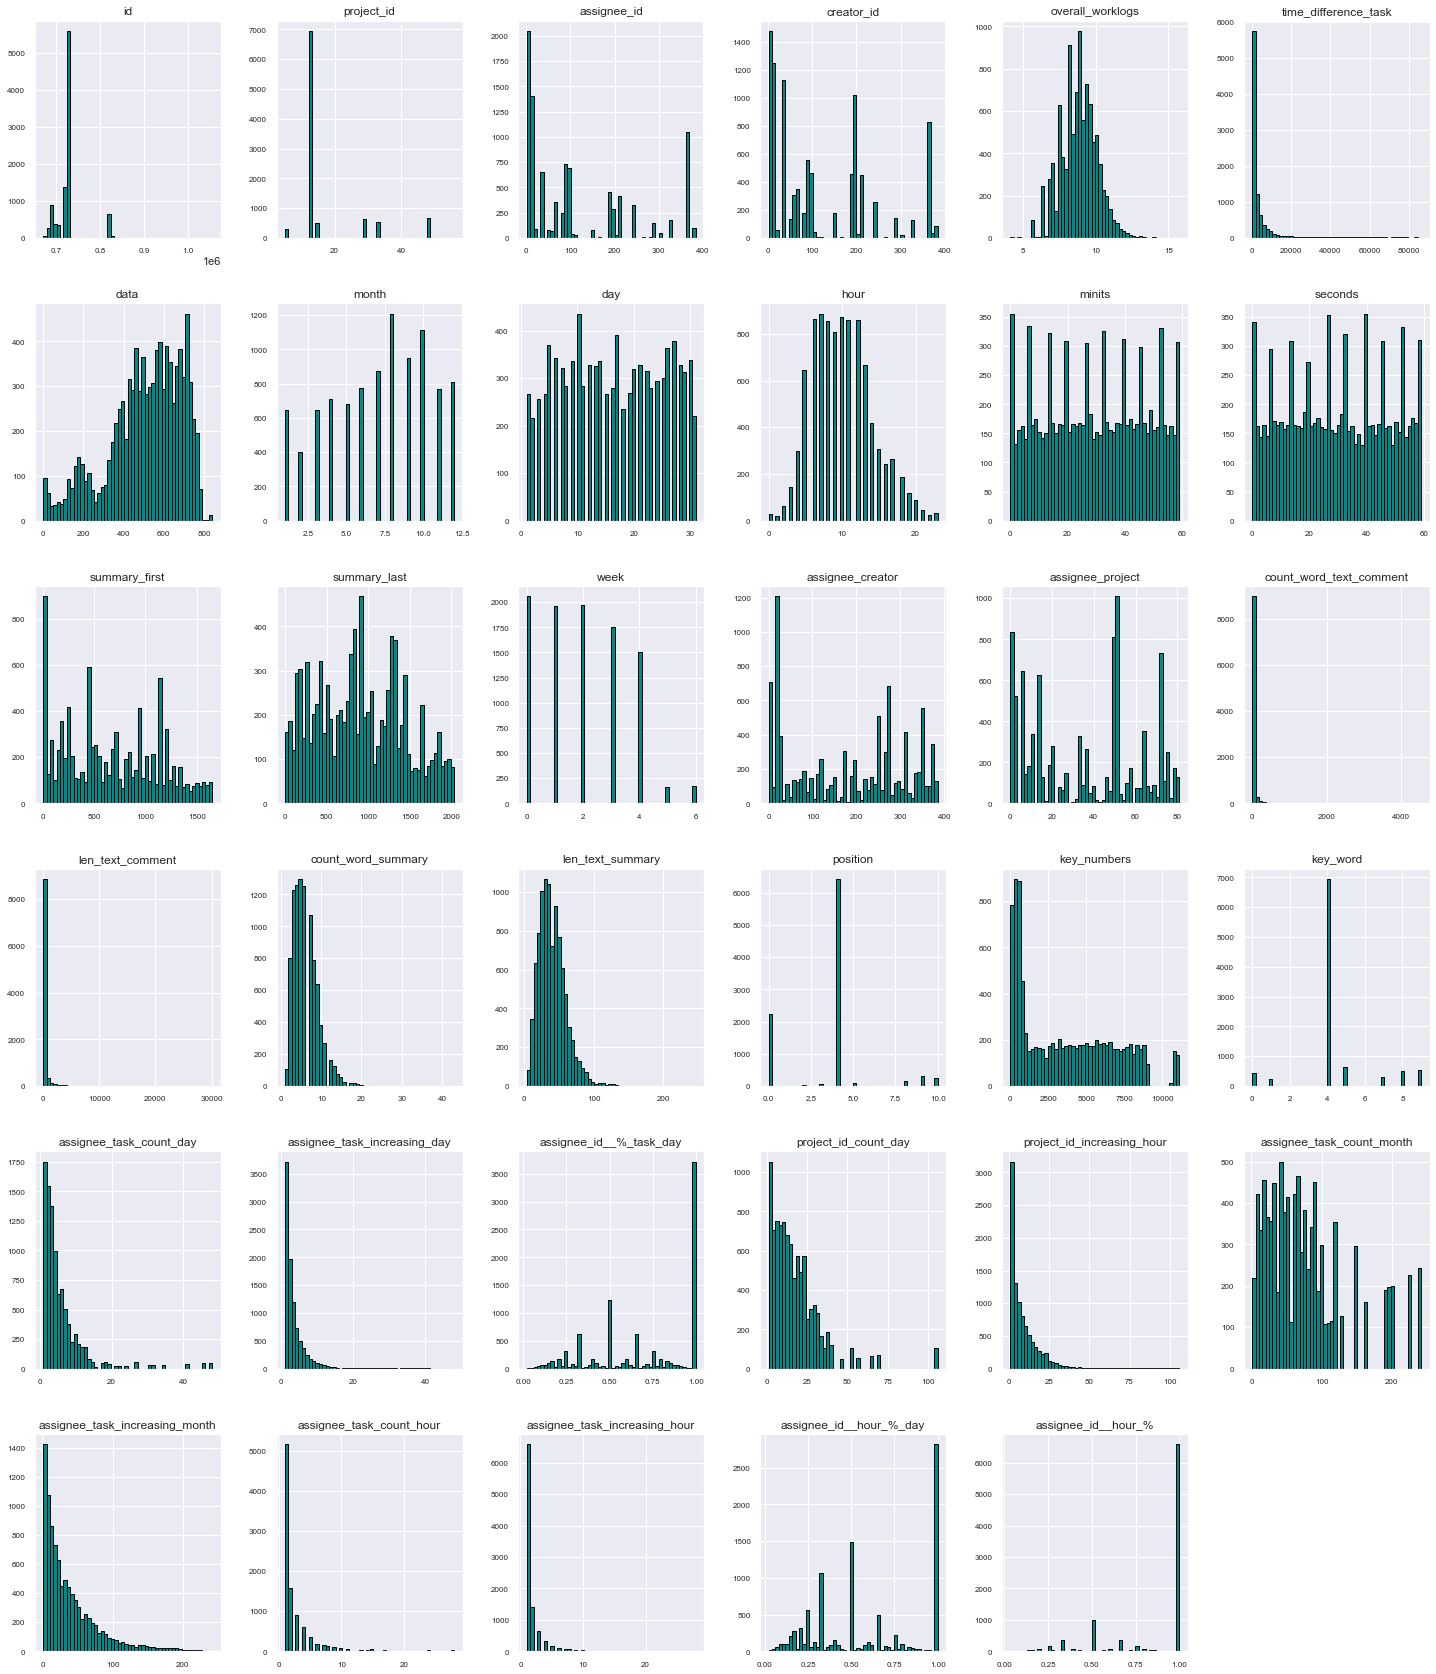

In [33]:
fig_ = train_final.hist(figsize=(25, 30), bins=50, color="darkcyan",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

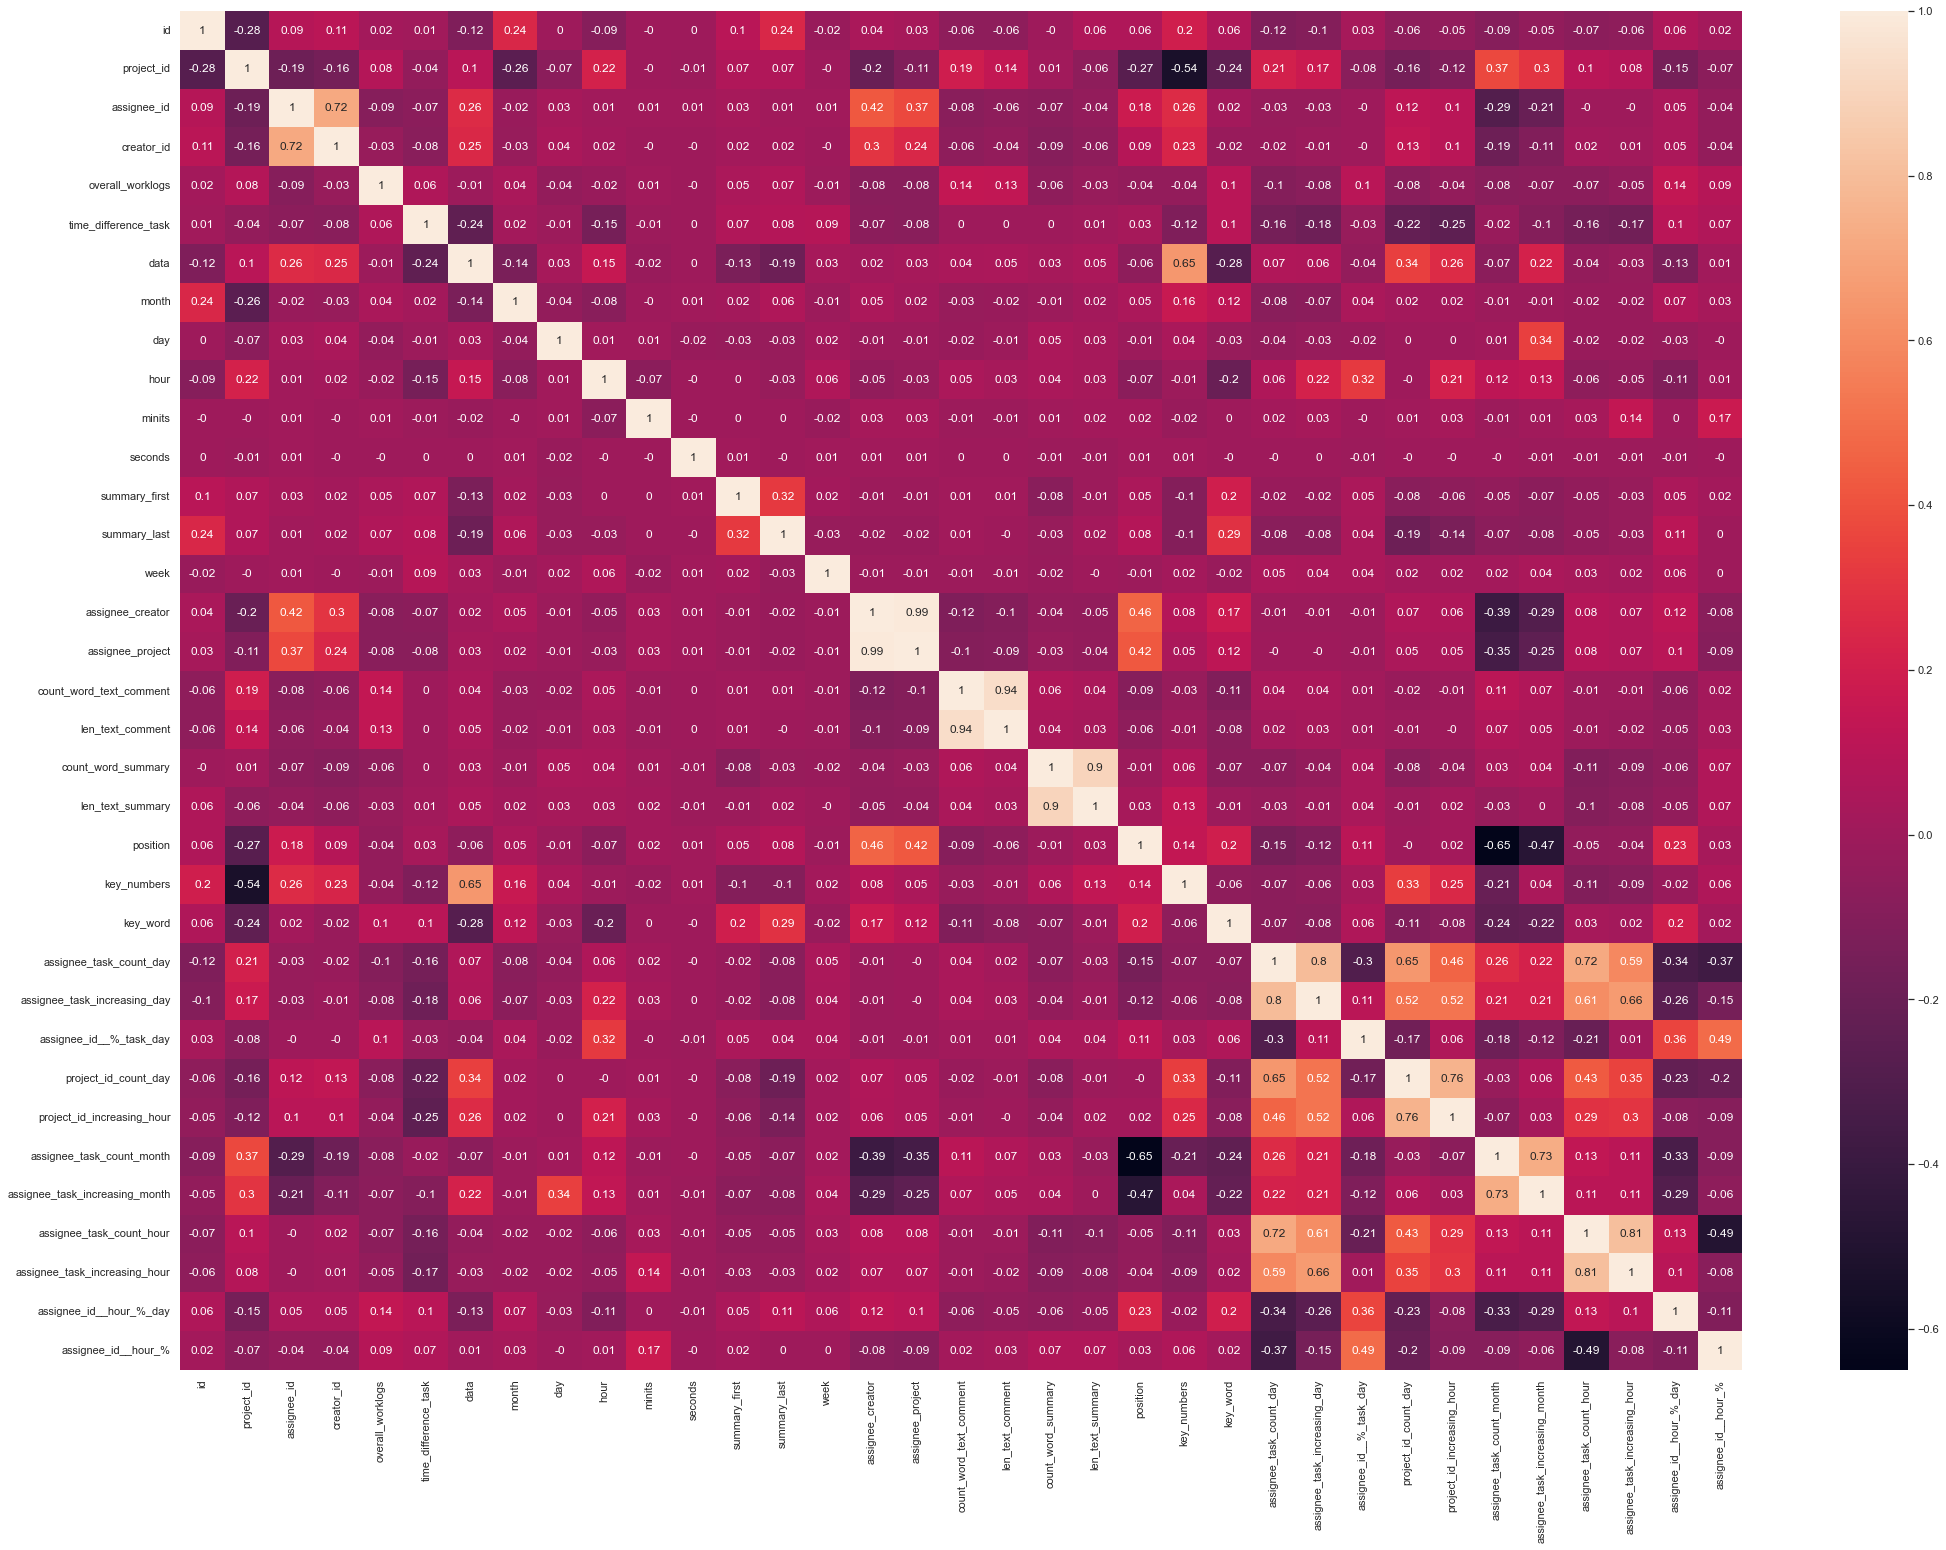

In [34]:
correlation_matrix = np.round(train_final.corr(),2)
fig = plt.figure(figsize=(35,25))
sns.heatmap(data=correlation_matrix, annot=True)

In [35]:
feature_del=['created','key','hour_minits_seconds','time','year','summary','summary_clean','data_hour','overall_worklogs','author_issue_id','text_comment']

In [36]:
train = train_final.drop(feature_del, axis = 1)
test= test_final.drop(feature_del, axis = 1)
targets = train_final.overall_worklogs.values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.1, random_state=42)

In [38]:
from catboost import CatBoostRegressor, Pool
pool_train_ = Pool(X_train, y_train, cat_features = ['summary_first','position','hour','data','key_word'])
pool_test_ = Pool(X_test, cat_features = ['summary_first','position','hour','data','key_word'])

model_cat_ = CatBoostRegressor(silent=True,eval_metric= 'R2')
model_cat_.fit(pool_train_,plot=True)
y_pred = model_cat_.predict(pool_test_)
print("Значение метрики R2 на test: ", r2_score(y_test, y_pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Значение метрики R2 на test:  0.32718441296987977


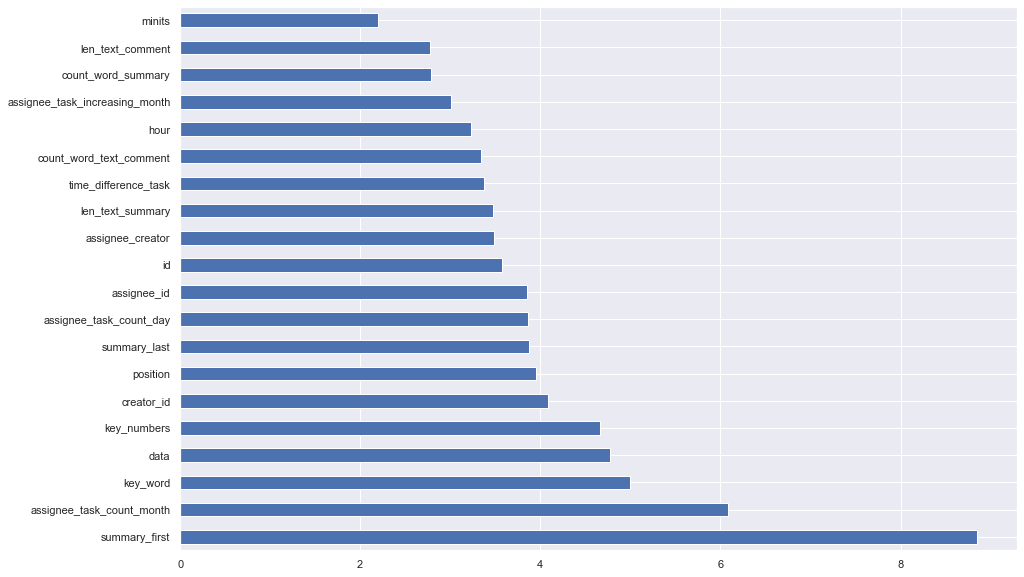

In [39]:
(pd.Series(model_cat_.feature_importances_, index=X_test.columns).nlargest(20).plot(kind='barh'))  
plt.show()

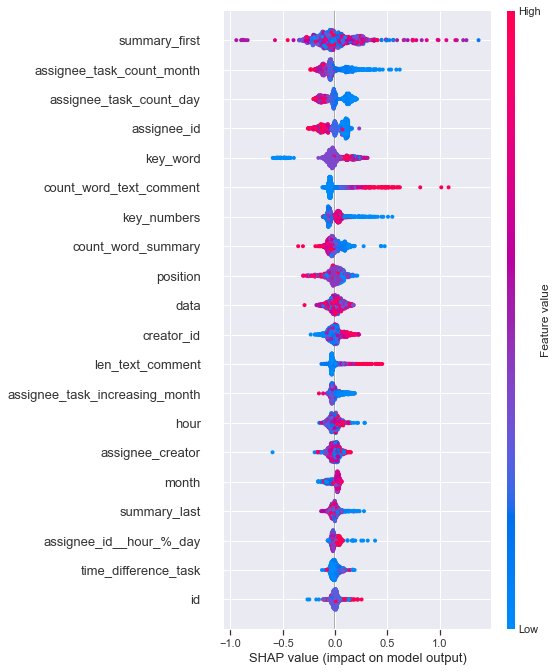

In [40]:
import shap 
explainer = shap.TreeExplainer(model_cat_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [41]:
pool_train = Pool(train, targets, cat_features = ['summary_first','position','hour','data','key_word'])
pool_test = Pool(test, cat_features = ['summary_first','position','hour','data','key_word'])
model_cat = CatBoostRegressor(silent=True,eval_metric= 'R2')
model_cat.fit(pool_train,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
score = np.expm1(model_cat.predict(pool_test))

In [43]:
submission = pd.DataFrame({
    "id" : test_final["id"].values,
    "overall_worklogs" : score
}) 

In [44]:
submission.to_csv("submission.csv", index=False)